In [1]:
# Now that  we have gotten the data, preprocessed it and explored it initially, we move on to the LDA topic analysis. 

# Import required packages to do LDA 
import re
import pandas as pd
import numpy as np
import networkx as nx
import itertools # peoblwm
import collections # problwm
import spacy
from pprint import pprint # problem 

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
# NLTK
from nltk import bigrams
from nltk.stem import PorterStemmer
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
#%matplotlib inlin


/anaconda3/envs/nlp/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/Astridll/.local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/Astridll/.local/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/Astridll/.local/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 

In [3]:
# LOAD PREPROCESSED DATA

# Data minus query
#tweets_df = pd.read_pickle('prepped_tweets_minus_query.pkl')
#tweets_df.head()

# data minus query + vaccine + vaccines
#tweets_df = pd.read_pickle('prepped_tweets_minus_query_vaccine_vaccines.pkl')
#tweets_df.head()

# data minus query + vaccine + vaccines + covid
#tweets_df = pd.read_pickle('prepped_tweets_minus_query_vaccine_vaccines_covid.pkl')
#tweets_df.head()

# use this for synopsis hand in version
# data minus query + vaccine + vaccines + covid + pfizer
#tweets_df = pd.read_pickle('prepped_tweets_minus_query_vaccine_vaccines_covid_pfizer.pkl')
#tweets_df.head()

# LINE BELOW ADDED AFTER SYNOPSIS HAND IN:
tweets_df = pd.read_pickle('updated_prepped_tweets_minus_query_vaccine_vaccines_covid_pfizer.pkl')
tweets_df.head()
#####

# Actually the preprocessing continues a little more before we can do LDA
# What we more do is the following: 
#  - Load preprocessed data minus query
#  - Add bigrams by making a list of the data with the added bigrams. Then apply this list when doing lemmetization. 
#  - Lemmetization (lemmas generated from bigram-data-list and addded as column in df)
#  - stemming (but generated from the no_stopwords_string which I guess is without the bigrams)

# - saving and reloading df in 4 versions (df1 where only the query/moderna is removed, df2 where vaccine and vaccines are removed additionally, df3 where covid is additionally removed, and df4 where pfizer is additionally removed)

#  - Because LDA models are performing horribly I removed top 10 most frequent words /lemmas from data, after this I excluded all tweets where lemmas < 3 (below 3). Also, I then removed any possible duplicates 
# Hopefully help, reduced from Before: (13435, 15) to After (). 



,text,location,statuses_count,followers_count,friends_count,listed_count,favourites_count,tidy_text,less_prep_text,tidy_text_tokens,tokens_no_stopwords,no_stopwords_string
0,The Future of Vaccines\nhttps://t.co/GI23fycj1...,Earth,11485,774,3240,2,1107,the future never before have billions people b...,The Future of Vaccines\n\nNever before have bi...,"[the, future, never, before, have, billions, p...","[future, never, billions, people, pressured, s...",future never billions people pressured submit
1,@AndrewButters91 *66 million (Moderna requires...,"Toronto, ON",10,110,732,1,9,million requires two doses,*66 million (Moderna requires two doses),"[million, requires, two, doses]","[million, requires, doses]",million requires doses
2,The immunization task force can likely deliver...,"Mississauga, Canada",280,225,675,3,26,the immunization task force can likely deliver...,The immunization task force can likely deliver...,"[the, immunization, task, force, can, likely, ...","[immunization, task, force, likely, deliver, s...",immunization task force likely deliver shots s...
3,"As I was writing this, Health Canada said it a...","New York, NY",9050,2826,4013,185,9650,was writing this health canada said authorized...,"As I was writing this, Health Canada said it a...","[was, writing, this, health, canada, said, aut...","[writing, health, canada, authorized]",writing health canada authorized
4,BREAKING: Health Canada authorizes Moderna's C...,"North Bay, Ontario",36196,4825,493,35,4,breaking health canada authorizes,BREAKING: Health Canada authorizes Moderna's C...,"[breaking, health, canada, authorizes]","[breaking, health, canada, authorizes]",breaking health canada authorizes


In [4]:
tweets_df.shape
# (13889, 13) - query (extra column is an irrelevant after preprocessing tweet_length column)
# (13718, 12) - query + vaccine + vaccines 
# (13583, 12) - query + vaccine + vaccines + covid
# (13435, 11) - query + vaccine + vaccines + covid + pfizer (one less column bc I skipped tweet_length)



(13435, 12)

In [59]:
# get most frequent words 
frequentw_list = pd.Series(' '.join(tweets_df.no_stopwords_string).split()).value_counts()[:30]
#tweets_df.head()
frequentw_list
#no_stopwords_string

# minus query 
# top 10 most frequntly used words 
#vaccine         7565
#covid           4049
#pfizer          2984
#vaccines        1624
#doses           1269
#first           1253
#health           903
#coronavirus      788
#trump            763
#fda              647

# minus query + vaccine + vaccines
# top 10 most frequntly used words 
#covid           4122
#pfizer          2960
#doses           1268
#first           1250
#health           903
#coronavirus      787
#trump            763
#fda              645
#week             602
#new              588

# minus query + vaccine + vaccines + covid
# top 10 most frequntly used words 
#pfizer          2952
#doses           1265
#first           1250
#health           903
#coronavirus      786
#trump            763
#fda              642
#week             602
#new              588
#today            536

# minus query + vaccine + vaccines + covid + pfizer
# top 10 most frequntly used words 
#doses           1262
#first           1250
#health           903
#coronavirus      783
#trump            761
#fda              642
#week             602
#new              588
#today            536
#receive          519


doses           1262
first           1250
health           903
coronavirus      783
trump            761
fda              642
week             602
new              588
today            536
receive          519
stock            490
fauci            484
received         473
people           442
approved         438
second           424
news             418
distribution     392
know             388
emergency        382
canada           368
side             362
mrna             356
says             334
monday           333
workers          329
shipments        328
shipment         300
getting          288
biontech         275
dtype: int64

In [5]:
# prepare to add bigrams and maybe trigrams (set of n_grams (words) that often occur together)
# make list of tokenized no_stopwords_string called data_token_words
# NB note - it is just a list and will therefore not be added as column in df 

# Tokenize words from column and put into list 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_token_words = list(sent_to_words(tweets_df['no_stopwords_string']))


In [ ]:
### About gensim.model.phrases

# `min_count` ignore all words and bigrams that have a total collected count below this 

# `threshold` stands for a threshold for forming  phrases (the higher value the fewer phrases). "A phrase of words `a` and `b` is accepted if `(cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold`, where `N` is the total vocabulary size."

# `max_vocab_size` loft for the size of the vocabulary. Applied to trim less common words. Default of 40M needs around 3.6GB of RAM; consider turning up and down for the 'max_vocab_size' dependent on the amount of available memory.

#`delimiter` is the character used to join collocation tokens (and should be a byte string as b'_').


In [6]:
# Add bigrams (and later maybe trigrams)

# Build bigram (and trigram) model
bigram = gensim.models.Phrases(data_token_words, min_count=6, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_token_words], threshold=100)
bigram_model = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]
#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]
# Form Bigrams
data_words_bigrams = make_bigrams(data_token_words)
# Form trigrams 
#data_words_trigrams = make_trigrams(data_token_words)


In [20]:
# See bigram example
print(data_words_bigrams[1140:1160])
# can e.g. see that bigrams such as:
# - allergic_reactions
# - allergic_reaction 
# - biotech_firm
# - approves_game
# - leaves_warehouses
# - expanding_immunization
# - side_effects
# - herd_immunity

[['choice', 'pfizer', 'biontech', 'vaccines', 'pick'], ['wait', 'brand', 'evolves'], ['unknown', 'whether', 'current', 'pfizer', 'vaccines', 'confer', 'even', 'short', 'term', 'immunity', 'new', 'strain'], ['nether', 'pfizer', 'clearly', 'explained', 'public', 'vaccines', 'effectively', 'immunize'], ['first', 'ever_consumer', 'facing', 'campaign', 'launched', 'comes'], ['glance', 'ingredient', 'lists', 'pfizer', 'sars_cov', 'vax', 'mindblowingly', 'benign'], ['yes', 'talking', 'glen', 'wrote', 'canada', 'vaccine'], ['vaccine', 'landed', 'hands', 'onslow', 'county', 'officials', 'tuesday', 'concerning', 'levels', 'cases', 'deaths'], ['pharmacies', 'soon', 'receiving', 'thousand', 'doses', 'covid', 'vaccine'], ['vaccine', 'landed', 'hands', 'onslow', 'county', 'officials', 'tuesday', 'concerning', 'levels', 'cases', 'deaths'], ['pfizer', 'trials', 'inadvertent', 'pregnant', 'people', 'trials', 'ppl', 'respectively', 'peop'], ['interesting', 'looks', 'evolution', 'vaccines', 'machine', 'v

In [7]:
# Lemmatization 
# Let's try to do lemmetization. Lemmatization transforms a word into its bsae form, e.g. "playing" --> "play", and “best” -> “good”. and "houses" --> "house"
# Use the spaCy package (open-source NLP library with different pre-built models)

# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner']) # Initialize spacy 'en' model, keeping only the tagger component

def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

# Lemmatizating bigram data (keeping only noun, adj, vb, adv)
tweets_df['lemmas'] = pd.Series(lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))

In [8]:
# NOT DOING THIS (could consider doing it...)  - did add lemmas as string though but did not remove duplicates

# MAYBE - REMOVE DUPLICATED
# Not sure if we should remove duplicates here. Having few tokens when lemmatizing could give duplicate rows. 
# add column to data which is lemmas as string 
# so that I can DROP DUPLICATES 

tweets_df['lemmas_string'] = [' '.join(map(str, l)) for l in tweets_df['lemmas']]
#tweets_df.head()
#tweets_df.drop_duplicates(subset=['lemmas_string'], keep='first',inplace=True)
# did not actually do, but could: tweets_df = tweets_df.drop(['lemmatized_string'], axis=1)
#tweets_df.reset_index(drop=True, inplace=True)
tweets_df.shape # 2280,15

(13435, 14)

In [140]:
# get most frequent words in lemmas
frequentw_list3 = pd.Series(' '.join(tweets_df.lemmas_string).split()).value_counts()[:30]
#tweets_df.head()
frequentw_list3
#lemmas_string
#vaccine, covid, pfizer not removed 
# - pfizer not here as lemmas are restricted to verbs, adjectives, nouns, and adverbiums 

# Top 10 frequnt lemmas (query removed) 
#vaccine         7445
#covid           3013
#dose            1368
#receive         1240
#first            941
#approve          663
#week             608
#begin            575
#shipment         563
#today            535

# Top 10 frequnt lemmas (query + vaccine + vaccines removed) 
#covid           2345
#dose            1361
#receive         1241
#first            983
#approve          653
#week             620
#shipment         598
#begin            584
#today            533
#stock            511

# Top 10 frequnt lemmas (query + vaccine + vaccines + covid removed) 
#dose            1373
#receive         1220
#first            971
#approve          637
#week             612
#shipment         589
#begin            572
#today            531
#stock            511
#people           443

# Top 10 frequnt lemmas (query + vaccine + vaccines + covid + pfizer removed) 
#dose            1378
#receive         1216
#first            980
#approve          635
#week             625
#shipment         595
#begin            570
#today            532
#stock            528
#new              444

dose            928
receive         778
first           658
week            434
today           410
trump           365
shipment        361
stock           345
people          330
approve         302
new             294
begin           283
expect          272
say             271
health          265
know            256
arrive          253
get             249
distribution    225
second          216
state           204
start           200
hospital        199
work            194
ship            188
go              188
think           179
good            175
worker          173
need            163
emergency       162
wait            157
vaccinate       157
trial           156
thank           155
update          147
care            147
vaccination     147
live            138
company         138
next            135
take            135
morning         128
virus           128
shot            127
money           126
administer      123
official        118
year            116
come            115


In [9]:
# STEMMING 
# Transforms all words into their root form by cutting of the suffix (can result in non-meaningful words).
# E.g. "animals" would be transformed into "anim" (but to "animal" when lemmatizing)
# Stemming and lemmetization both contributes to "dimensionality reduction" 

# STEMMING - NB note that stemming is not on bigram data - maybe change this later
stemmer = PorterStemmer()
tweets_df['stemmed'] = tweets_df['tokens_no_stopwords'].apply(lambda x : [stemmer.stem(y) for y in x])


In [11]:
#tweets_df.head()
tweets_df.shape 
# (13889, 16) q
# (13718, 15) q + vacc
# (13583, 15) q + vacc + covid
# (13435, 14) q + vacc + covid + pfizer

(13435, 15)

In [67]:
# get most frequent words stemmed 
# adding a column of stemmed words in string format 
tweets_df['stemmed_string'] = [' '.join(map(str, l)) for l in tweets_df['stemmed']]

frequentw_list4 = pd.Series(' '.join(tweets_df.stemmed_string).split()).value_counts()[:30]
#tweets_df.head()
frequentw_list4

# Overview of top 10 most frequent stemmed words (only q removed)
#vaccin        9787
#covid         4050
#pfizer        2990
#dose          1507
#receiv        1268
#first         1253
#health         903
#approv         884
#coronaviru     789
#trump          789

# Overview of top 10 most frequent stemmed words (only q + vaccine + vaccines removed)
#covid         4137
#pfizer        2966
#dose          1505
#receiv        1264
#first         1250
#health         903
#approv         873
#trump          790
#coronaviru     788
#week           675

# Overview of top 10 most frequent stemmed words (only q + vaccine + vaccines + covid removed)
#pfizer        2958
#dose          1502
#receiv        1259
#first         1250
#health         903
#approv         860
#trump          790
#coronaviru     787
#week           675
#fda            643

# Overview of top 10 most frequent stemmed words (only q + vaccine + vaccines + covid + pfizer removed)
#dose          1497
#receiv        1257
#first         1250
#health         903
#approv         858
#trump          788
#coronaviru     784
#week           674
#fda            643
#shipment       628

dose          1497
receiv        1257
first         1250
health         903
approv         858
trump          788
coronaviru     784
week           674
fda            643
shipment       628
distribut      620
vaccin         594
new            588
stock          583
arriv          562
author         555
today          538
fauci          484
state          484
expect         461
begin          452
shot           450
peopl          448
second         424
news           418
ship           415
know           410
hospit         395
emerg          393
say            382
dtype: int64

In [12]:
# SAVING UPDATED DATAFRAME WITH LEMMAS AND STEMMED WORDS 

# minus query 
# # save to csv file:
#tweets_df.to_csv('updated_stemmedlemmas_data_minus_q.csv', header=True, mode='a')
# save to pickle 
#tweets_df.to_pickle('updated_stemmedlemmas_data_minus_q.pkl')

# minus query + vaccine + vaccines
# save to csv file:
# tweets_df.to_csv('updated_stemmedlemmas_data_minus_q_vaccine.csv', header=True, mode='a')
# save to pickle 
# tweets_df.to_pickle('updated_stemmedlemmas_data_minus_q_vaccine.pkl')

# minus query + vaccine + vaccines + covid
# save to csv file:
# tweets_df.to_csv('updated_stemmedlemmas_data_minus_q_vaccine_covid.csv', header=True, mode='a')
# save to pickle 
# tweets_df.to_pickle('updated_stemmedlemmas_data_minus_q_vaccine_covid.pkl')

# minus query + vaccine + vaccines + covid + pfizer
# save to csv file:
#tweets_df.to_csv('updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.csv', header=True, mode='a')
# save to pickle 
#tweets_df.to_pickle('updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.pkl')


# LINES BELOW ADDED AFTER SYNOPSIS HAND IN: 
# updated df with less preprocessed column (data minus query + vaccine + vaccines + covid + pfizer)
# save to csv file:
tweets_df.to_csv('new_updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.csv', header=True, mode='a')
# save to pickle 
tweets_df.to_pickle('new_updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.pkl')



###### THIS IS THE END OF THE PREPROCESSING AND WE NOW MOVE ON TO BUILD MODELS ######### 

In [10]:
# Now open each of the 4 versions of the preprocessed df as df 1-4

# df1 = data minus (query) 
#df1 = pd.read_pickle('updated_stemmedlemmas_data_minus_q.pkl')

# df2 = data minus (query + vaccine + vaccines)
#df2 = pd.read_pickle('updated_stemmedlemmas_data_minus_q_vaccine.pkl')

# df3 = data minus (query + vaccine + vaccines + covid)
#df3 = pd.read_pickle('updated_stemmedlemmas_data_minus_q_vaccine_covid.pkl')

# df4 = data minus (query + vaccine + vaccines + covid + pfizer)
#df4 = pd.read_pickle('updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.pkl')

# LINE BELOW ADDED AFTER SYNOPSIS HAND IN
df5 = pd.read_pickle('new_updated_stemmedlemmas_data_minus_q_vaccine_covid_pfizer.pkl')

In [11]:
# check that it is the correct data
# (NB column numbers vary bc I included a block that add a column w tweet character length in 1-3, and also a post preprocessing tweet character length column in df1)
# 
# #df1.shape #(13889, 17)
#df2.shape #(13718, 16)
#df3.shape #(13583, 16)
df4.shape #(13435, 15)
#df4.head()


(13435, 15)

In [263]:
#### OBS - DO NOT RUN FOR UPDATED DF WITH ADDED LESS PREPROCESSED COLUMN
# RUN BLOCK BELOW INSTEAD

#  REMOVING 10 MOST FREQUENT LEMMAS IN ORDER TO GET MORE COHERENT TOPICS 
# ADDING COLUMN LEMMAS_REDUCED TO CHECK OUT TOPIC MODELING MINUS MOST FREQUENT LEMMAS

# Excluding 10 most common words (lemmas) to see if it improves model performance - it does, a lot! But discuss cost
# Top 10 frequent lemmas (when query is removed) 
#vaccine         7445 - already gone in df4
#covid           3013 - already gone in df4 
#dose            1368-
#receive         1240-
#first            941-
#approve          663-
#week             608-
#begin            575-
#shipment         563-
#today            535-


def remove_1_word(tweet):
    tweet_no_1 = re.sub(r"dose", "", tweet)
    return tweet_no_1
df4['lemmas_string'] = np.vectorize(remove_1_word)(df4['lemmas_string'])
def remove_2_word(tweet):
    tweet_no_2 = re.sub(r"receive", "", tweet)
    return tweet_no_2
df4['lemmas_string'] = np.vectorize(remove_2_word)(df4['lemmas_string'])
def remove_3_word(tweet):
    tweet_no_3 = re.sub(r"first", "", tweet)
    return tweet_no_3
df4['lemmas_string'] = np.vectorize(remove_3_word)(df4['lemmas_string'])
def remove_4_word(tweet):
    tweet_no_4 = re.sub(r"approve", "", tweet)
    return tweet_no_4
df4['lemmas_string'] = np.vectorize(remove_4_word)(df4['lemmas_string'])
def remove_5_word(tweet):
    tweet_no_5 = re.sub(r"week", "", tweet)
    return tweet_no_5
df4['lemmas_string'] = np.vectorize(remove_5_word)(df4['lemmas_string'])
def remove_6_word(tweet):
    tweet_no_6 = re.sub(r"begin", "", tweet)
    return tweet_no_6
df4['lemmas_string'] = np.vectorize(remove_6_word)(df4['lemmas_string'])
def remove_7_word(tweet):
    tweet_no_7 = re.sub(r"shipment", "", tweet)
    return tweet_no_7
df4['lemmas_string'] = np.vectorize(remove_7_word)(df4['lemmas_string'])
def remove_8_word(tweet):
    tweet_no_8 = re.sub(r"today", "", tweet)
    return tweet_no_8
df4['lemmas_string'] = np.vectorize(remove_8_word)(df4['lemmas_string'])


In [12]:
# THIS BLOCK IS ADDED AFTER SYNOPSIS HAND IN 
def remove_1_word(tweet):
    tweet_no_1 = re.sub(r"dose", "", tweet)
    return tweet_no_1
df5['lemmas_string'] = np.vectorize(remove_1_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_1_word)(df5['less_prep_text'])

def remove_2_word(tweet):
    tweet_no_2 = re.sub(r"receive", "", tweet)
    return tweet_no_2
df5['lemmas_string'] = np.vectorize(remove_2_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_2_word)(df5['less_prep_text'])

def remove_3_word(tweet):
    tweet_no_3 = re.sub(r"first", "", tweet)
    return tweet_no_3
df5['lemmas_string'] = np.vectorize(remove_3_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_3_word)(df5['less_prep_text'])

def remove_4_word(tweet):
    tweet_no_4 = re.sub(r"approve", "", tweet)
    return tweet_no_4
df5['lemmas_string'] = np.vectorize(remove_4_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_4_word)(df5['less_prep_text'])

def remove_5_word(tweet):
    tweet_no_5 = re.sub(r"week", "", tweet)
    return tweet_no_5
df5['lemmas_string'] = np.vectorize(remove_5_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_5_word)(df5['less_prep_text'])

def remove_6_word(tweet):
    tweet_no_6 = re.sub(r"begin", "", tweet)
    return tweet_no_6
df5['lemmas_string'] = np.vectorize(remove_6_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_6_word)(df5['less_prep_text'])

def remove_7_word(tweet):
    tweet_no_7 = re.sub(r"shipment", "", tweet)
    return tweet_no_7
df5['lemmas_string'] = np.vectorize(remove_7_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_7_word)(df5['less_prep_text'])

def remove_8_word(tweet):
    tweet_no_8 = re.sub(r"today", "", tweet)
    return tweet_no_8
df5['lemmas_string'] = np.vectorize(remove_8_word)(df5['lemmas_string'])
df5['less_prep_text'] = np.vectorize(remove_8_word)(df5['less_prep_text'])


In [13]:
# add column that is the tokenized lemmas_string (just bc I could not make it work with the lemmas column, had to be a string to do it this way, so now I need to return it to the right format which I can do with the tokenize function bc it splits the string by whitespace)
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  
df5['lemmas_reduced'] = list(tokenize(df5['lemmas_string']))

In [265]:
print(df4['lemmas_reduced'])

0               [never, billion, people, pressure, submit]
1                                                [require]
2        [immunization, likely, deliver, shot, small, r...
3                                       [write, authorize]
4                                       [break, authorize]
                               ...                        
13430    [already, exhibit, death, unknown, volunteer, ...
13431                               [authorize, emergency]
13432                            [authorize, supply, next]
13433                                                   []
13434    [throttle, push, warp_speed, ahead, baby, bet,...
Name: lemmas_reduced, Length: 13435, dtype: object


In [14]:
# Because I am concerned about the state of my LDA models, I will try to reduce noise by removing short tweets, i.e. tweets that are only one or two lemmas. 

# RUN FOR HAND IN VERSION OF DF 
# Remove tweets that only have two or less (AKA below 3) lemmas:
#df4['length'] = df4['lemmas_reduced'].apply(len)
#df4 = df4.drop(df4[df4['length']<3].index) # evt 4
#df4 = df4.drop(['length'], axis=1)
#df4.reset_index(drop=True, inplace=True)

# Also remove duplicates: 
#df4.drop_duplicates(subset=['lemmas_string'], keep='first',inplace=True)
#df4.reset_index(drop=True, inplace=True)

#df4.shape 
# FOR LEMMASREDUCED + BELOW 3 + DROP DUPLICATES = (8406, 16)
#(for df4 below 3 + drop duplicates: 9193)

###############################################################
# CODE BELOW IS ADDED AFTER SYNOPSIS HAND IN 
# Remove tweets that only have two or less (AKA below 3) lemmas:
df5['length'] = df5['lemmas_reduced'].apply(len)
df5 = df5.drop(df5[df5['length']<3].index) # evt 4
df5 = df5.drop(['length'], axis=1)
df5.reset_index(drop=True, inplace=True)

# Also remove duplicates: 
df5.drop_duplicates(subset=['lemmas_string'], keep='first',inplace=True)
df5.reset_index(drop=True, inplace=True)

df5.shape 
# FOR LEMMASREDUCED + BELOW 3 + DROP DUPLICATES = (8406, 16)

# the reason why the df still have 16 columns as the previous version is bc I dont have the stemmed_string column in this updated version

(8406, 16)

In [16]:
# SAVING AND LOADING FINAL VERSION OF THE DATA

# Save df4 with the latest alterations so we can begin bulding models 
# Alterations include: 
#   - remove all instances of words from the top 10 list of most frequent lemmas (disregarding the previously removed query)
#   - Remove all rows that has less than 3 lemmas to work with
#   - Remove possible duplicates 

# save to csv file:
#df4.to_csv('final_data_version_minustop10.csv', header=True, mode='a')
# save to pickle 
#df4.to_pickle('final_data_version_minustop10.pkl')

# Read data
#df4 = pd.read_pickle('final_data_version_minustop10.pkl')
# remember to use column lemmas_reduced instead of lemmas! 


# CODE BELOW ADDED AFTER SYNOPSIS HAND IN
# save to csv file:
df5.to_csv('oralexamupdated_final_data_version_minustop10.csv', header=True, mode='a')
# save to pickle 
df5.to_pickle('oralexamupdated_final_data_version_minustop10.pkl')

# Read data
df5 = pd.read_pickle('oralexamupdated_final_data_version_minustop10.pkl')
# remember to use column lemmas_reduced instead of lemmas! 



###### NOW THIS IS TRULY THE END OF THE PREPROCESSING AND WE NOW MOVE ON TO BUILD MODELS ######### 

In [19]:
######## BUID MODELS ########
# FIRST WITH GENSIM
# THEN WITH MALLET
#############################
df5.head()


,text,location,statuses_count,followers_count,friends_count,listed_count,favourites_count,tidy_text,less_prep_text,tidy_text_tokens,tokens_no_stopwords,no_stopwords_string,lemmas,lemmas_string,stemmed,lemmas_reduced
0,The Future of Vaccines\nhttps://t.co/GI23fycj1...,Earth,11485,774,3240,2,1107,the future never before have billions people b...,The Future of Vaccines\n\nNever before have bi...,"[the, future, never, before, have, billions, p...","[future, never, billions, people, pressured, s...",future never billions people pressured submit,"[never, billion, people, pressure, submit]",never billion people pressure submit,"[futur, never, billion, peopl, pressur, submit]","[never, billion, people, pressure, submit]"
1,The immunization task force can likely deliver...,"Mississauga, Canada",280,225,675,3,26,the immunization task force can likely deliver...,The immunization task force can likely deliver...,"[the, immunization, task, force, can, likely, ...","[immunization, task, force, likely, deliver, s...",immunization task force likely deliver shots s...,"[immunization, likely, deliver, shot, small, r...",immunization likely deliver shot small rural h...,"[immun, task, forc, like, deliv, shot, small, ...","[immunization, likely, deliver, shot, small, r..."
2,Question if city staff will remain out working...,Toronto,251890,19164,9952,607,30736,question city staff will remain out working wi...,Question if city staff will remain out working...,"[question, city, staff, will, remain, out, wor...","[question, city, staff, remain, working, homel...",question city staff remain working homeless pe...,"[question, city, staff, remain, work, homeless...",question city staff remain work homeless peopl...,"[question, citi, staff, remain, work, homeless...","[question, city, staff, remain, work, homeless..."
3,@iamIqraKhalid @GovCanHealth @moderna_tx Enoug...,"Ontario, Canada",41897,1317,883,5,156959,enough for people big whoppy population canada...,"Enough for 84,000 people! Big Whoppy Do. ...","[enough, for, people, big, whoppy, population,...","[enough, people, big, whoppy, population, cana...",enough people big whoppy population canada millio,"[enough, people, big]",enough people big,"[enough, peopl, big, whoppi, popul, canada, mi...","[enough, people, big]"
4,.@USForcesKorea will start administering the @...,"Washington, DC",33658,16782,1181,529,558,will start administering the its members this ...,. will start administering the COVID-19 to i...,"[will, start, administering, the, its, members...","[start, administering, members, week]",start administering members week,"[start, administer, member, week]",start administer member,"[start, administ, member, week]","[start, administer, member]"


In [268]:
# Before we can build the LDA model we have to generate a dicitonary and a corpus. These are two main inputs in the model, and can be created with the gensim package. 

# Create Dictionary:

# lemmas dictionary
id2word_lemmas = corpora.Dictionary(df4['lemmas_reduced'])
print(id2word_lemmas)
#Dictionary(5737 unique tokens: ['billion', 'never', 'people', 'pressure', 'submit']...)
 
# tokens dictionary 
#id2word_tokens = corpora.Dictionary(tweets_df['tokens_no_stopwords'])
#print(id2word_tokens)

# Create Corpus:

# lemmas corpus
tweets_lemmas = df4['lemmas_reduced']

# token corpus 
#tweets_tokens = tweets_df['tokens_no_stopwords']


Dictionary(5737 unique tokens: ['billion', 'never', 'people', 'pressure', 'submit']...)


In [269]:
# What the corpus looks like
# Corpus length: 8406
len(tweets_lemmas)

8406

In [270]:
# A unique ID is assigned to each word and the corpus is represented in version of a tuple as tuple (word_id,word_frequency)

# Term Document Frequency
corpus_lemmas = [id2word_lemmas.doc2bow(tweet) for tweet in tweets_lemmas]
#corpus_tokens = [id2word_tokens.doc2bow(tweet) for tweet in tweets_tokens]

In [80]:
########### BUILDING THE LDA MODEL ############

In [112]:
# LDA models are built with inspiration from an article from machinelearningplus that goes over an example of how to do LDA topic modeling with gensim. More information and more about how to interpret visualisations can be found here https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (also used in class)

# DONT RUN 
# Build LDA model - with lemmas
# Now we initialize with number of topics k = ?, which will be changed and adjusted 
# try with 10 topicszzzz
lda_model_lemmas = gensim.models.ldamodel.LdaModel(corpus=corpus_lemmas,
                                           id2word=id2word_lemmas,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=16,
                                           alpha= 'auto',
                                           per_word_topics=True)

In [34]:
# Build LDA model - with tokens 
# DONT RUN 
# Now we initialize with number of topics k = ?, which will be changed and adjusted 
# try with 10 topicszzzz
lda_model_tokens = gensim.models.ldamodel.LdaModel(corpus=corpus_tokens,
                                           id2word=id2word_tokens,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=16,
                                           alpha= 'auto',
                                           per_word_topics=True)

In [113]:
# Get evaluation metrics - COHERENCE SCORE 
# lemmas model

# DONT RUN

# also for fun see perplexity, dont really use this 
print('\nPerplexity: ', lda_model_lemmas.log_perplexity(corpus_lemmas))  
# offers a measure of how good the model actually is. The lower the better.

# Coherence Score
# change out the c_v coherence with u_mass for faster computation
coherence_model_lda = CoherenceModel(model=lda_model_lemmas, texts=tweets_lemmas, dictionary=id2word_lemmas, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# With 8 topics I have a coherence score of 0.6162 # from old dataset
# 8: perplexity -7.9359 # from old dataset 


Perplexity:  -7.93589828684483

Coherence Score:  0.6162289980301385


In [35]:
# Get evaluation metrics - COHERENCE SCORE 
# lemmas model

# DONT RUN 

# also for fun see perplexity, dont really use this 
# Perplexity
print('\nPerplexity: ', lda_model_tokens.log_perplexity(corpus_tokens))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tokens = CoherenceModel(model=lda_model_tokens, texts=tweets_tokens, dictionary=id2word_tokens, coherence='c_v')
coherence_lda_tokens = coherence_model_lda_tokens.get_coherence()
print('\nCoherence Score: ', coherence_lda_tokens)

# With 10 topics I have a coherence score of 0.6327
# 10 : perplexity -8.3956


Perplexity:  -9.060419745134636

Coherence Score:  0.5910795641425967


In [165]:
############### Visualisation of topic modeling #######
#os.getcwd()

'/Users/Astridll/Desktop/Kandidat CogSci/1_Semester/Natural Language Processing/NLP_exam_code'

In [114]:
# Visualize the topics-keywords

# DONT RUN 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_lemmas, corpus_lemmas, id2word_lemmas)
vis




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.077017  0.275813       1        1  14.010238
7     -0.341766  0.009203       2        1  13.615231
2      0.065843 -0.215016       3        1  13.354447
0      0.042383  0.002677       4        1  12.891637
6      0.042937 -0.003293       5        1  12.384558
4      0.054033 -0.079024       6        1  12.182258
3      0.035738  0.010766       7        1  11.596590
1      0.023816 -0.001126       8        1   9.965042, topic_info=               Term        Freq       Total Category  logprob  loglift
60        emergency  131.000000  131.000000  Default  30.0000  30.0000
96         approval   99.000000   99.000000  Default  29.0000  29.0000
9             trial   89.000000   89.000000  Default  28.0000  28.0000
50        effective   79.000000   79.000000  Default  27.0000  27.0000
14            first   71.000000   71.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
224         promise    7.313097    8.032976   Topic8  -5.0188   2.2122
525          reason    7.043385    7.763785   Topic8  -5.0563   2.2087
2151            mad    6.587224    7.308352   Topic8  -5.1233   2.2022
1583            man    6.325815    7.048477   Topic8  -5.1638   2.1979
222   effectiveness    6.109761    6.829062   Topic8  -5.1985   2.1948

[270 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
382       3  0.970381          accord
605       1  0.977752  administration
569       4  0.952269             ago
448       7  0.937132           allow
266       1  0.961083         already
...     ...       ...             ...
82        1  0.987731            week
308       2  0.908786            well
304       1  0.992557            work
56        2  0.975204            year
309       8  0.936744             yet

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 3, 1, 7, 5, 4, 2])

In [ ]:
# USE MALLET FOR TOPIC MODELLING
##### Finding best mallet lda model ##### 

In [122]:
# Mallet LDA model
from gensim.models.wrappers import LdaMallet

# Previous models are created with a gensim inbuilt LDA algorithm. 
# However, the version of the LDA algorithm from Mallet often gives higher quality topics.
# We can implement mallet in gensim though a gensim wrapper 
# First, download zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. 
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#Users/Astridll/Desktop/Kandidat CogSci/1_Semester/Natural Language Processing/NLP_exam_code/mallet-2.0.8/bin/mallet

In [156]:
# best mallet lda model 
# returns c_v cohenerence metrics for different number of topics 
def compute_coherence_values(dictionary, corpus, iterations_no, texts, limit, start=2, step=3, ): # optimize_interval_no,

    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics

    mallet_path = './mallet-2.0.8/bin/mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_stemmed, num_topics=10, id2word=id2word_stemmed, optimize_interval=20, iterations=1000)
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tweets_stemmed, dictionary=id2word_stemmed, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=iterations_no)# optimize_interval=optimize_interval_no
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [157]:
# RETURN TO DO THIS - FIRST TRYING TO RUN SINGLE MALLET MODEL BELOW TO SEE HOW LONG IT TAKES TO RUN 
# alpha and update interval parameter made performance worse!

mallet_path = './mallet-2.0.8/bin/mallet'

# use funtion from above: 
model_list, coherence_values = compute_coherence_values(dictionary=id2word_lemmas, corpus=corpus_lemmas,iterations_no=1000, texts=tweets_lemmas, start=2, limit=26, step=2) # alpha=0.001 removed

#model_list, coherence_values = compute_coherence_values(dictionary=id2word_tokens, corpus=corpus_tokens,optimize_interval_no=20, iterations_no=1000, texts=tweets_tokens, start=2, limit=18, step=3) 

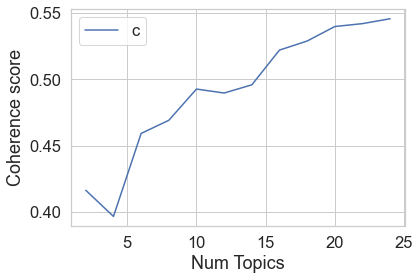

In [158]:
# Show graph of models with different numbers of topics vs coherence scores 
limit=26; start=2; step=2; 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [159]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
# LEMMAS: 
#Num Topics = 2  has Coherence Value of 0.6452
#Num Topics = 5  has Coherence Value of 0.7227
#Num Topics = 8  has Coherence Value of 0.752
#Num Topics = 11  has Coherence Value of 0.7548
#Num Topics = 14  has Coherence Value of 0.7626
#Num Topics = 17  has Coherence Value of 0.7406
#Num Topics = 20  has Coherence Value of 0.7652
#Num Topics = 23  has Coherence Value of 0.7727
#Num Topics = 26  has Coherence Value of 0.7688
#Num Topics = 29  has Coherence Value of 0.7666

#Num Topics = 2  has Coherence Value of 0.6421
#Num Topics = 4  has Coherence Value of 0.7284
#Num Topics = 6  has Coherence Value of 0.745
#Num Topics = 8  has Coherence Value of 0.7591
#Num Topics = 10  has Coherence Value of 0.7633
#Num Topics = 12  has Coherence Value of 0.7355
#Num Topics = 14  has Coherence Value of 0.7661
# AND SO I LAND ON 7 TOPICS, AS IT CAN BE SEEN THAT THERE IS NO BIG ADDED VALUE OF ADDING MORE

# LEMMAS - BUT WITH LOW ALPHA
#Num Topics = 2  has Coherence Value of 0.4642
#Num Topics = 5  has Coherence Value of 0.5013
#Num Topics = 8  has Coherence Value of 0.5075
#Num Topics = 11  has Coherence Value of 0.4931
#Num Topics = 14  has Coherence Value of 0.5098

# ADDED DATA 15000 - LEMMAS, NO ALPHA SPECIFIED 
#Num Topics = 2  has Coherence Value of 0.3852
#Num Topics = 5  has Coherence Value of 0.4027
#Num Topics = 8  has Coherence Value of 0.434
#Num Topics = 11  has Coherence Value of 0.4728
#Num Topics = 14  has Coherence Value of 0.4871
#Num Topics = 17  has Coherence Value of 0.5101

# extra data is CRAP! (errors?) 

# ADDED DATA 15000 - LEMMAS, LOW ALPHA - so bad
#Num Topics = 2  has Coherence Value of 0.3936
#Num Topics = 5  has Coherence Value of 0.3908
#Num Topics = 8  has Coherence Value of 0.3647
#Num Topics = 11  has Coherence Value of 0.3691
#Num Topics = 14  has Coherence Value of 0.3515
#Num Topics = 17  has Coherence Value of 0.3552

# try with no alpha / default and more range
#Num Topics = 2  has Coherence Value of 0.3157
#Num Topics = 4  has Coherence Value of 0.3429
#Num Topics = 6  has Coherence Value of 0.4025
#Num Topics = 8  has Coherence Value of 0.4168
#Num Topics = 10  has Coherence Value of 0.4872
#Num Topics = 12  has Coherence Value of 0.4734
#Num Topics = 14  has Coherence Value of 0.4859
#Num Topics = 16  has Coherence Value of 0.501
#Num Topics = 18  has Coherence Value of 0.4993
#Num Topics = 20  has Coherence Value of 0.5064
#Num Topics = 22  has Coherence Value of 0.5225
#Num Topics = 24  has Coherence Value of 0.5298

# dropped lemmas below 3
#Num Topics = 2  has Coherence Value of 0.3474
#Num Topics = 4  has Coherence Value of 0.3823
#Num Topics = 6  has Coherence Value of 0.4075
#Num Topics = 8  has Coherence Value of 0.4397
#Num Topics = 10  has Coherence Value of 0.4688
#Num Topics = 12  has Coherence Value of 0.4777
#Num Topics = 14  has Coherence Value of 0.477
#Num Topics = 16  has Coherence Value of 0.4964
#Num Topics = 18  has Coherence Value of 0.5009
#Num Topics = 20  has Coherence Value of 0.5254
#Num Topics = 22  has Coherence Value of 0.5172
#Num Topics = 24  has Coherence Value of 0.5342

# now also removed duplicate lemma rows 
# did not help

# NOW WITH DATA MINUS 10 MOST FREQUENT WORDS/LEMMAS - FINAL DATA
#Num Topics = 2  has Coherence Value of 0.4165
#Num Topics = 4  has Coherence Value of 0.3968
#Num Topics = 6  has Coherence Value of 0.4593
#Num Topics = 8  has Coherence Value of 0.4692
#Num Topics = 10  has Coherence Value of 0.4927 # MY CHOSEN MODEL FOR LDA
#Num Topics = 12  has Coherence Value of 0.4897
#Num Topics = 14  has Coherence Value of 0.4959
#Num Topics = 16  has Coherence Value of 0.522
#Num Topics = 18  has Coherence Value of 0.5289
#Num Topics = 20  has Coherence Value of 0.5398
#Num Topics = 22  has Coherence Value of 0.542
#Num Topics = 24  has Coherence Value of 0.5456

# GONNA GO WITH 10 TOPICS - NOT EXACTLY GREATEST COHERENCE VALUES BUT TOPICS LOOK GOOD AND YOU ALSO HAVE TO THINK ABOUT IT AS A TRADE OF AT SOME POINT. EVEN THOUGH 24+ TOPICS MIGHT GIVE A HIGHER COHERENCE SCORE IT IS NOT SURE I WOULD GAIN MORE INFORMATION OUT OF IT BC I WOULD NOT GET A FEELING OF TOPICS THERE WOULD BE TOO MANY TO COMPREHEND I THINK

Num Topics = 2  has Coherence Value of 0.4165
Num Topics = 4  has Coherence Value of 0.3968
Num Topics = 6  has Coherence Value of 0.4593
Num Topics = 8  has Coherence Value of 0.4692
Num Topics = 10  has Coherence Value of 0.4927
Num Topics = 12  has Coherence Value of 0.4897
Num Topics = 14  has Coherence Value of 0.4959
Num Topics = 16  has Coherence Value of 0.522
Num Topics = 18  has Coherence Value of 0.5289
Num Topics = 20  has Coherence Value of 0.5398
Num Topics = 22  has Coherence Value of 0.542
Num Topics = 24  has Coherence Value of 0.5456


In [211]:
type(model_topics)

#[(0,
#  [('health', 0.0759565962307253),
#   ('worker', 0.049971444888635065),
#   ('care', 0.0422615648201028),
#   ('live', 0.041119360365505425),
#   ('official', 0.034837235865219876),
#   ('administer', 0.034551684751570534),
#   ('watch', 0.030553969160479727),
#   ('case', 0.03026841804683038),
#   ('report', 0.02655625356938892),
#   ('facility', 0.023129640205596803)]),
# (1,
#  [('work', 0.06459874786568014),
#   ('virus', 0.03699487763232783),
#   ('great', 0.026750142287990893),
#   ('scientist', 0.024758110415480934),
#   ('initial', 0.016789982925441094),
#   ('long', 0.01593625498007968),
#   ('leave', 0.014228799089356859),
#   ('science', 0.013944223107569721),
#   ('total', 0.013375071143995446),
#   ('truck', 0.012805919180421172)]),
# (2,
#  [('hospital', 0.05507990867579909),
#   ('wait', 0.0502283105022831),
#   ('distribute', 0.030251141552511414),
#   ('country', 0.028824200913242008),
#   ('share', 0.02454337899543379),
#   ('deliver', 0.021974885844748857),
#   ('million', 0.021974885844748857),
#   ('government', 0.01997716894977169),
#   ('yesterday', 0.01769406392694064),
#   ('break', 0.017408675799086757)]),
# (3,
#  [('stock', 0.11947397873531057),
#   ('trump', 0.11219921656407386),
#   ('company', 0.03329602686066033),
#   ('order', 0.030498041410184668),
#   ('hold', 0.027700055959709008),
#   ('invest', 0.02294348069390039),
#   ('buy', 0.02238388360380526),
#   ('family', 0.01650811415780638),
#   ('true', 0.01259093452714046),
#   ('vaccin', 0.011751538891997761)]),
# (4,
#  [('ship', 0.05554005023723137),
#   ('state', 0.054981858777560705),
#   ('start', 0.05386547585821937),
#   ('vaccination', 0.040189785096288025),
#   ('news', 0.03349148758024002),
#   ('include', 0.023444041306168017),
#   ('plan', 0.022048562656991347),
#   ('set', 0.021769466927156013),
#   ('ready', 0.020094892548144012),
#   ('shoot', 0.019536701088473347)]),
# (5,
#  [('expect', 0.07158899494665918),
#   ('arrive', 0.06878158338012352),
#   ('good', 0.04997192588433464),
#   ('update', 0.04211117349803481),
#   ('end', 0.028916339135317236),
#   ('day', 0.025547445255474453),
#   ('hear', 0.018809657495788883),
#   ('pandemic', 0.017967434025828188),
#   ('feel', 0.017967434025828188),
#   ('morning', 0.01768669286917462)]),
# (6,
#  [('emergency', 0.052146355517142036),
#   ('money', 0.04436761740132527),
#   ('authorize', 0.03486027081532699),
#   ('authorization', 0.03399596658023624),
#   ('approval', 0.032843560933448576),
#   ('month', 0.02881014116969173),
#   ('follow', 0.021031403053874964),
#   ('question', 0.019878997407087293),
#   ('reason', 0.017862287525208874),
#   ('administration', 0.016709881878421203)]),
# (7,
#  [('people', 0.10596221959858323),
#  ('vaccinate', 0.04693034238488784),
#   ('shot', 0.04043683589138135),
#   ('read', 0.03571428571428571),
#   ('time', 0.029811097992916175),
#   ('develop', 0.028630460448642266),
#   ('recommend', 0.02154663518299882),
#   ('require', 0.01829988193624557),
#   ('safe', 0.01770956316410862),
#   ('group', 0.015938606847697757)]),
# (8,
#  [('trial', 0.050400916380297825),
#   ('year', 0.0352233676975945),
#   ('find', 0.02720504009163803),
#   ('hope', 0.02663230240549828),
#   ('test', 0.02577319587628866),
#   ('phase', 0.020332187857961054),
#   ('strain', 0.02004581901489118),
#   ('effective', 0.01918671248568156),
#   ('datum', 0.018327605956471937),
#   ('coronavirus', 0.017468499427262314)]),
# (9,
#  [('distribution', 0.0667818077144502),
#   ('roll', 0.0256188831318365),
#   ('speed', 0.025331030512377662),
#   ('part', 0.025043177892918825),
#   ('continue', 0.018998272884283247),
#   ('big', 0.018422567645365574),
#   ('give', 0.018422567645365574),
#   ('back', 0.017846862406447898),
#   ('announce', 0.017846862406447898),
#   ('happen', 0.017271157167530225)])]


list

In [ ]:
distribution_of_top10w_for_topics_df = df.groupby('sentiment')['Dominant_Topic'].value_counts().unstack().fillna(0)


In [209]:
# Select the model and print the topics
optimal_model = model_list[4] # x topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20)) # 10
# show the distribution of the top 10 words for each topic

"""
[(0,
  '0.076*"health" + 0.050*"worker" + 0.042*"care" + 0.041*"live" + '
  '0.035*"official" + 0.035*"administer" + 0.031*"watch" + 0.030*"case" + '
  '0.027*"report" + 0.023*"facility"'),
 (1,
  '0.065*"work" + 0.037*"virus" + 0.027*"great" + 0.025*"scientist" + '
  '0.017*"initial" + 0.016*"long" + 0.014*"leave" + 0.014*"science" + '
  '0.013*"total" + 0.013*"truck"'),
 (2,
  '0.055*"hospital" + 0.050*"wait" + 0.030*"distribute" + 0.029*"country" + '
  '0.025*"share" + 0.022*"deliver" + 0.022*"million" + 0.020*"government" + '
  '0.018*"yesterday" + 0.017*"break"'),
 (3,
  '0.119*"stock" + 0.112*"trump" + 0.033*"company" + 0.030*"order" + '
  '0.028*"hold" + 0.023*"invest" + 0.022*"buy" + 0.017*"family" + 0.013*"true" '
  '+ 0.012*"vaccin"'),
 (4,
  '0.056*"ship" + 0.055*"state" + 0.054*"start" + 0.040*"vaccination" + '
  '0.033*"news" + 0.023*"include" + 0.022*"plan" + 0.022*"set" + 0.020*"ready" '
  '+ 0.020*"shoot"'),
 (5,
  '0.072*"expect" + 0.069*"arrive" + 0.050*"good" + 0.042*"update" + '
  '0.029*"end" + 0.026*"day" + 0.019*"hear" + 0.018*"pandemic" + 0.018*"feel" '
  '+ 0.018*"morning"'),
 (6,
  '0.052*"emergency" + 0.044*"money" + 0.035*"authorize" + '
  '0.034*"authorization" + 0.033*"approval" + 0.029*"month" + 0.021*"follow" + '
  '0.020*"question" + 0.018*"reason" + 0.017*"administration"'),
 (7,
  '0.106*"people" + 0.047*"vaccinate" + 0.040*"shot" + 0.036*"read" + '
  '0.030*"time" + 0.029*"develop" + 0.022*"recommend" + 0.018*"require" + '
  '0.018*"safe" + 0.016*"group"'),
 (8,
  '0.050*"trial" + 0.035*"year" + 0.027*"find" + 0.027*"hope" + 0.026*"test" + '
  '0.020*"phase" + 0.020*"strain" + 0.019*"effective" + 0.018*"datum" + '
  '0.017*"coronavirus"'),
 (9,
  '0.067*"distribution" + 0.026*"roll" + 0.025*"speed" + 0.025*"part" + '
  '0.019*"continue" + 0.018*"big" + 0.018*"give" + 0.018*"back" + '
  '0.018*"announce" + 0.017*"happen"')]
  """

[(0,
  '0.076*"health" + 0.050*"worker" + 0.042*"care" + 0.041*"live" + '
  '0.035*"official" + 0.035*"administer" + 0.031*"watch" + 0.030*"case" + '
  '0.027*"report" + 0.023*"facility" + 0.021*"line" + 0.020*"death" + '
  '0.017*"public" + 0.017*"stop" + 0.016*"patient" + 0.015*"top" + '
  '0.013*"local" + 0.011*"spread" + 0.010*"reach" + 0.010*"vac"'),
 (1,
  '0.065*"work" + 0.037*"virus" + 0.027*"great" + 0.025*"scientist" + '
  '0.017*"initial" + 0.016*"long" + 0.014*"leave" + 0.014*"science" + '
  '0.013*"total" + 0.013*"truck" + 0.012*"produce" + 0.012*"lead" + '
  '0.011*"real" + 0.011*"protect" + 0.011*"world" + 0.011*"explain" + '
  '0.010*"turn" + 0.010*"clear" + 0.009*"fast" + 0.009*"company"'),
 (2,
  '0.055*"hospital" + 0.050*"wait" + 0.030*"distribute" + 0.029*"country" + '
  '0.025*"share" + 0.022*"million" + 0.022*"deliver" + 0.020*"government" + '
  '0.018*"yesterday" + 0.017*"break" + 0.015*"issue" + 0.014*"small" + '
  '0.014*"send" + 0.012*"medical" + 0.012*"deal" 

'\n[(0,\n  \'0.076*"health" + 0.050*"worker" + 0.042*"care" + 0.041*"live" + \'\n  \'0.035*"official" + 0.035*"administer" + 0.031*"watch" + 0.030*"case" + \'\n  \'0.027*"report" + 0.023*"facility"\'),\n (1,\n  \'0.065*"work" + 0.037*"virus" + 0.027*"great" + 0.025*"scientist" + \'\n  \'0.017*"initial" + 0.016*"long" + 0.014*"leave" + 0.014*"science" + \'\n  \'0.013*"total" + 0.013*"truck"\'),\n (2,\n  \'0.055*"hospital" + 0.050*"wait" + 0.030*"distribute" + 0.029*"country" + \'\n  \'0.025*"share" + 0.022*"deliver" + 0.022*"million" + 0.020*"government" + \'\n  \'0.018*"yesterday" + 0.017*"break"\'),\n (3,\n  \'0.119*"stock" + 0.112*"trump" + 0.033*"company" + 0.030*"order" + \'\n  \'0.028*"hold" + 0.023*"invest" + 0.022*"buy" + 0.017*"family" + 0.013*"true" \'\n  \'+ 0.012*"vaccin"\'),\n (4,\n  \'0.056*"ship" + 0.055*"state" + 0.054*"start" + 0.040*"vaccination" + \'\n  \'0.033*"news" + 0.023*"include" + 0.022*"plan" + 0.022*"set" + 0.020*"ready" \'\n  \'+ 0.020*"shoot"\'),\n (5,\n  \

In [206]:
# Save

# dictionary = id2word_stemmed (what they call id2word)
# corpus = corpus_stemmed (what they call corpus)
# text = tweets_stemmed (what they call data_lemmatized)
optimal_model.save('optimal_mallet_model_10_topics.gensim')
# ldamallet = gensim.models.wrappers.LdaMallet.load('lda_mallet_model.gensim')
#id2word_lemmas.save('id2word_lemmas_dictionary.gensim')
# id2word_stemmed = corpora.Dictionary.load('id2word_stemmed_dictionary.gensim')


In [258]:
# I AM HERE NOW  - RUNNING SINGLE MODEL TO TEST TOPICS AND DOMINANT TOPICS 
# RETURN TO DO MULTIPLE MODELS LATER 

# OR DO A SINGLE MALLET MODEL 
# NOT NECESSARY IF USING ONE OF THE MODELS FROM ABOVE (FROM MODEL LIST)
#import os
#from gensim.models.wrappers import LdaMallet

#os.environ.update({'MALLET_HOME':r'C:/Users/Astridll/Desktop/Kandidat CogSci/1_Semester/Natural Language Processing/NLP_exam_code/mallet-2.0.8/'})
#os.environ.update({'MALLET_HOME':r'C:/Users/Astridll/Desktop/Kandidat CogSci/1_Semester/Natural Language Processing/NLP_exam_code/new_mallet/mallet-2.0.8/'})
#mallet_path = './Users/Astridll/Desktop/Kandidat CogSci/1_semester/Natural Language Processing/NLP_exam_code/mallet-2.0.8/bin/mallet'
#./bin/mallet 
#r'C:\Users\Astridll\Desktop\Kandidat CogSci\1_semester\Natural Language Processing\NLP_exam_code\mallet-2.0.8\bin\mallet'
#mallet_path = r'C:\Users\Astridll\Desktop\Kandidat CogSci\1_semester\Natural Language Processing\NLP_exam_code\mallet-2.0.8\bin\mallet' # update this path
#mallet_path = r'C:\Users\Astridll\Desktop\Kandidat CogSci\1_semester\Natural Language Processing\NLP_exam_code\new_mallet\mallet-2.0.8\bin\mallet' # update this path
mallet_path = './mallet-2.0.8/bin/mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_lemmas, num_topics=10, id2word=id2word_lemmas, iterations=1000) # optimize interval changed from 20 to 100 # , optimize_interval=100

#ldamallet7_alpha = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_lemmas, num_topics=7, id2word=id2word_lemmas, alpha=0.001, iterations=1000)
#ldamallet7_t = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tokens, num_topics=7, id2word=id2word_tokens, optimize_interval=20, iterations=1000)

#mallet_path = 'C:/Users/Astridll/Desktop/Kandidat CogSci/1_Semester/Natural Language Processing/NLP_exam_code/mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_stemmed, num_topics=10, id2word=id2word_stemmed)

#### WOHOOOOOOOOOO IT FINALLY WORKED !!!!!!!!!!! ######## :D :D :D :D :D :D 

In [259]:
# THIS IS A CONTIUATION OF THE SINGLE MALLET LDA MODEL - ALSO NOT NECESSARY IF USING MODEL FROM MODEL LIST COMPUTING COHERENCE SCORES ... 


# Show Topics
pprint(ldamallet.show_topics(num_words=10)) # changed from (formatted=False)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tweets_lemmas, dictionary=id2word_lemmas, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# for 10 topics: 0.5009 - topics look quite good
# for 9 topics: 0.4883
# for 20 topics: 0.5521
# for 16 topics: 0.5218
# for 6 topics: 

[(0,
  '0.059*"state" + 0.041*"company" + 0.032*"case" + 0.027*"find" + '
  '0.026*"report" + 0.026*"day" + 0.022*"ready" + 0.021*"death" + 0.021*"line" '
  '+ 0.019*"continue"'),
 (1,
  '0.055*"ship" + 0.040*"shot" + 0.035*"year" + 0.030*"approval" + '
  '0.027*"hope" + 0.021*"morning" + 0.021*"follow" + 0.018*"require" + '
  '0.018*"feel" + 0.015*"create"'),
 (2,
  '0.117*"stock" + 0.109*"trump" + 0.042*"money" + 0.030*"order" + '
  '0.027*"hold" + 0.024*"speed" + 0.018*"pay" + 0.017*"call" + 0.016*"family" '
  '+ 0.015*"push"'),
 (3,
  '0.059*"start" + 0.054*"hospital" + 0.041*"vaccination" + 0.029*"end" + '
  '0.024*"government" + 0.024*"deliver" + 0.023*"care" + 0.023*"facility" + '
  '0.022*"set" + 0.022*"rollout"'),
 (4,
  '0.075*"health" + 0.070*"arrive" + 0.051*"emergency" + 0.050*"worker" + '
  '0.040*"live" + 0.034*"official" + 0.034*"administer" + '
  '0.033*"authorization" + 0.027*"watch" + 0.019*"care"'),
 (5,
  '0.075*"expect" + 0.067*"distribution" + 0.044*"update" + 0.

In [69]:
# Checking the topics
print(optimal_model)

In [161]:
# name of model optimal_model
from tethne.networks import topics

In [260]:
ldamal = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
###undo ### model_10 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model) 
#model_optimal = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model) # currently 10

#from tethne.networks import topics
#from tethne import gensim_to_theta_featureset
#theta = gensim_to_theta_featureset(lda_model_lemmas, corpus_lemmas)
#from tethne import feature_cooccurrence
#graph = feature_cooccurrence(theta, min_weight=0.05)
#termGraph = topics.terms(ldamallet, threshold=0.01)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamal, corpus_lemmas, id2word_lemmas)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.160779 -0.119056       1        1  10.051714
8      0.177601 -0.198996       2        1  10.012852
6     -0.194613  0.191819       3        1  10.011018
3      0.172958  0.195600       4        1   9.996144
1      0.191514  0.000703       5        1   9.995233
9     -0.002912 -0.143546       6        1   9.994553
0     -0.033027 -0.221800       7        1   9.994077
7     -0.156537  0.092326       8        1   9.984284
4      0.166530  0.179964       9        1   9.982624
5     -0.160736  0.022987      10        1   9.977501, topic_info=            Term        Freq       Total Category  logprob  loglift
312        stock  491.000000  491.000000  Default  30.0000  30.0000
350        trump  457.000000  457.000000  Default  29.0000  29.0000
2         people  430.000000  430.000000  Default  28.0000  28.0000
112       health  309.000000  309.000000  Default  27.0000  27.0000
143       expect  310.000000  310.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1410      review   26.768278   27.961824  Topic10  -5.0428   2.2612
1579   recommend   60.836996   88.268679  Topic10  -4.2219   1.9327
577   scientific   24.334798   25.517862  Topic10  -5.1381   2.2574
721        newly   34.068718   43.389197  Topic10  -4.8017   2.0630
860       chance   26.768278   35.115431  Topic10  -5.0428   2.0334

[673 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       8  0.990087  absolutely
324       6  0.998947      accord
371       7  0.920431         add
371      10  0.055784         add
506       4  0.991789  additional
...     ...       ...         ...
2366      2  0.850447         wow
1125      2  0.992188       write
206       7  0.998963       wrong
144       5  1.002931        year
412       9  0.996764   yesterday

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 4, 2, 10, 1, 8, 5, 6])

In [281]:
# Finding the dominant topic in each sentence

# Topic modeling can help us in discovering what each document is about (what topic).
# In order to so, we locate the highest precentage-wise contributing topic for each document 

 
# function that finds dominant topic and returns overview of topic contribution in a table:

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# call function
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_lemmas, texts=tweets_lemmas) # maybe change texts=tweets_stemmed to the sentence instead of the tokens? 

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [280]:
len(tweets_lemmas)


8406

In [207]:
# save dominant topic df
# save to csv file:
df_dominant_topic.to_csv('df_dominant_topic_10_topics.csv', header=True, mode='a')
# save to pickle 
df_dominant_topic.to_pickle('df_dominant_topic_10_topics.pkl')

In [180]:
liste = []
for i in df_dominant_topic.Dominant_Topic:
    if i == 0:
        liste.append(i)
print(len(liste))

# 0 = 1163
# 1 = 1041
# 2 = 943
# 3 = 996
# 4 = 771
# 5 = 772
# 6 = 742
# 7 = 676
# 8 = 671
# 9 = 631

# IN TOTAL 8406

1163
